<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.CrowdCounting/blob/saving_training_output/1_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod

# PEP8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager

# Setup paths

In [5]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/7.CrowdCounting/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/7.CrowdCounting/Models/trial_1 already exists


# Helper functions

In [27]:
from keras import backend as K
from keras.utils.layer_utils import count_params

def count_parameters(model):
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    return {
        'Total parameters': trainable_count + non_trainable_count,
        'Trainable parameters': trainable_count,
        'Non-trainable parameters': non_trainable_count
    }

# Data split

In [6]:
frames_directory = os.path.join(manager.data_root_path, 'frames')
labels_df = pd.read_csv(os.path.join(manager.data_root_path, 'labels.csv'))
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
print(labels_df.head(1))

   id  count      image_name
0   1     35  seq_000001.jpg


In [7]:
TRAINVAL_SIZE = 0.2  # 0.8
RANDOM_STATE = 42

trainval_labels_df, test_labels_df = train_test_split(
    labels_df,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
)
trainval_labels_df.shape, test_labels_df.shape

((400, 3), (1600, 3))

# Classes definition

In [8]:
from tensorflow.keras.models import Model

class NNModel(ABC):
    def __init__(
        self,
        name_,
        input_image_size_,
        validation_split_,
        batch_size_,
        trainval_labels_df_,
        test_labels_df_
    ):
        self.random_state = 42
        self.name = name_
        self.input_image_size = input_image_size_
        self.validation_split = validation_split_
        self.batch_size = batch_size_


        self.data_generator_parameters = None
        self.train_generator = None
        self.validation_generator = None
        self.test_generator = None
        self.model = None
        self.init_data_generator_parameters()
        self.init_data_generators(
            trainval_labels_df_,
            test_labels_df_
        )
    
    def __repr__(self):
        return f'''
            {
                self.random_state,
                self.name,
                self.input_image_size,
                self.validation_split,
                self.batch_size
            }
        '''
    @abstractmethod
    def init_data_generator_parameters(self):
        # Augmentation / preprocessing parameters
        pass
    
    def init_data_generators(self, trainval_labels_df_, test_labels_df_):
        trainval_data_generator = ImageDataGenerator(
            **self.data_generator_parameters,
            validation_split=self.validation_split)

        test_data_generator = ImageDataGenerator(
            **self.data_generator_parameters)
        
        common_flow_params = dict(
            directory=frames_directory,
            x_col='image_name',
            y_col='count',
            target_size=self.input_image_size,
            color_mode='rgb',
            class_mode='raw',
            batch_size=self.batch_size,
            shuffle=True,
            seed=self.random_state
        )

        self.train_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='training',
            dataframe=trainval_labels_df_
        )

        self.validation_generator = trainval_data_generator.flow_from_dataframe(
            **common_flow_params,
            subset='validation',
            dataframe=trainval_labels_df_
        )

        self.test_generator = test_data_generator.flow_from_dataframe(
            **common_flow_params,
            dataframe=test_labels_df_
        )

    def visualize_data(self):
        X_batch, Y_batch = next(self.train_generator)
        print(X_batch.shape, np.max(X_batch), np.min(X_batch))

        _, ax = plt.subplots(3, 3)
        ax = ax.flatten()
        for i in range(9):
            ax[i].imshow(X_batch[i])
            ax[i].set_title(Y_batch[i])
            ax[i].axis('off')

        _, ax_hist = plt.subplots()
        ax.hist.hist(Y_batch)
        
    @abstractmethod
    def prepare_model(self):
        pass

    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse', 'mae']
        )

    def unfreeze_n_layers(self, n_layers_to_freeze_):
        assert n_layers_to_freeze_ > 0

        for layer in self.model.layers[:-n_layers_to_freeze_]:
            layer.trainable = False
        for layer in self.model.layers[-n_layers_to_freeze_:]:
            layer.trainable = True
    
    def fit(self, epochs_, callbacks_):
        self.learning_history = self.model.fit_generator(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs_,
            callbacks=callbacks_
        )
        return self.learning_history

## Resnet

In [9]:
from tensorflow.keras.applications import resnet50
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,

)

class ResNetModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.resnet50.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = resnet50.ResNet50(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Xception

In [28]:
from tensorflow.keras.applications.xception import Xception


class XceptionModel(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,  # 1./255,
            preprocessing_function=tf.keras.applications.xception.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = Xception(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Inception V3

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


class InceptionV3Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionV3(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## Inception Resnet V2

In [30]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


class InceptionResnetV2Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.\
                keras.\
                applications.\
                inception_resnet_v2.\
                preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = InceptionResNetV2(
            weights='imagenet',
            pooling='avg',
            input_shape=(299, 299, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## VGG16

In [31]:
from tensorflow.keras.applications.vgg16 import VGG16


class VGG16Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def init_data_generator_parameters(self):
        print(f'VGG16: init data generator parameters')
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=tf.keras.applications.vgg16.preprocess_input
        )
    
    def prepare_model(self):
        feature_extractor = VGG16(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

## VGG19

In [32]:
from tensorflow.keras.applications.vgg19 import VGG19


class VGG19Model(NNModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_data_generator_parameters(self):
        self.data_generator_parameters = dict(
            rescale=None,
            preprocessing_function=\
                tf.keras.applications.vgg19.preprocess_input
        )

    def prepare_model(self):
        feature_extractor = VGG19(
            weights='imagenet',
            pooling='avg',
            input_shape=(224, 224, 3),
            include_top=False
        )
        x = feature_extractor.output
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(units=400, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(units=1, activation='linear')(x)

        self.model = Model(
            inputs=feature_extractor.input,
            outputs=outputs
        )

# Comparison of validation performance

In [75]:
common_params = dict(
    validation_split_=0.2,
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

MODELS = {
    'resnet': ResNetModel(
        name_='resnet',
        input_image_size_=(224, 224),
        **common_params
    ),
    'xception': XceptionModel(
        name_='xception',
        input_image_size_=(299, 299),
        **common_params
    ),
    'inception_v3': InceptionV3Model(
        name_='inception_v3',
        input_image_size_=(299, 299),
        **common_params
    )

}

Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.
Found 320 validated image filenames.
Found 80 validated image filenames.
Found 1600 validated image filenames.


In [76]:
def collect_comparison_data(models_dict_):
    validation_results = {}
    model_parameters = {}

    for model_name, model_object in MODELS.items():
        print(f'Working with {model_name}')

        model_object.prepare_model()
        model_object.compile_model()

        model_object.model.load_weights(
            os.path.join(
                manager.models_trial_path,
                model_object.name,
                model_object.name
            )
        )
        validation_results[model_name] = model_object.model.evaluate(
            model_object.validation_generator
        )
        model_parameters[model_name] = count_parameters(model_object.model)
        
    return {
        'validation_results': validation_results,
        'model_parameters': model_parameters
    }

In [77]:
comparison_data = collect_comparison_data(MODELS)

Working with resnet


2/2 [==============================] - 19s 3s/step - loss: 8.1138 - mse: 8.1138 - mae: 2.2562
Working with xception
2/2 [==============================] - 30s 6s/step - loss: 9.3450 - mse: 9.3450 - mae: 2.3724
Working with inception_v3
2/2 [==============================] - 20s 4s/step - loss: 8.4677 - mse: 8.4677 - mae: 2.2880


In [78]:
comparison_data

{'validation_results': {'resnet': [8.113811492919922,
   8.113811492919922,
   2.2562203407287598],
  'xception': [9.344964981079102, 9.344964981079102, 2.3723535537719727],
  'inception_v3': [8.467727661132812, 8.467727661132812, 2.288046360015869]},
 'model_parameters': {'resnet': {'Total parameters': 24568113,
   'Trainable parameters': 24514993,
   'Non-trainable parameters': 53120},
  'xception': {'Total parameters': 21841881,
   'Trainable parameters': 21787353,
   'Non-trainable parameters': 54528},
  'inception_v3': {'Total parameters': 22783185,
   'Trainable parameters': 22748753,
   'Non-trainable parameters': 34432}}}

In [82]:
import pandas as pd


def plot_validation_results(validation_performance_dict_):
    mae_dict = {
        model_name: [data[2]] \
        for model_name, data in validation_performance_dict_.items()
    }
    
    df = pd.DataFrame(mae_dict, index=None)
    df = df.T
    print(df)
    df = df.sort_values(by=0)
    
    ax = df.plot(kind='bar')
    ax.set_ylabel('Mean absolute error')
    ax.set_xlabel('Model')
    ax.set_title('Validation performance of baseline models')
    ax.get_legend().remove()
    ax.grid()

                     0
resnet        2.256220
xception      2.372354
inception_v3  2.288046


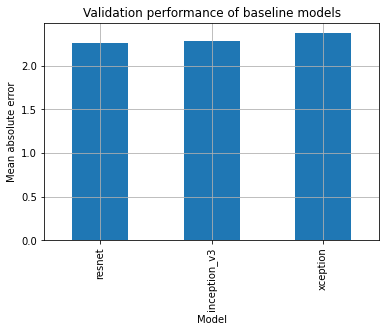

In [83]:
plot_validation_results(comparison_data['validation_results'])

# ResNet baseline evaluation

In [10]:
resnet = ResNetModel(
    name_='resnet',
    input_image_size_=(224, 224),
    validation_split_=0.95,  # fraction of images, reserved for validation
    batch_size_=64,
    trainval_labels_df_=trainval_labels_df,
    test_labels_df_=test_labels_df
)

resnet.prepare_model()
resnet.compile_model()

Found 20 validated image filenames.
Found 380 validated image filenames.
Found 1600 validated image filenames.
94765736/94765736 [==============================] - 1s 0us/step


In [11]:
resnet.model.load_weights(
    os.path.join(
        manager.models_trial_path,
        resnet.name,
        resnet.name
    )
)

In [12]:
resnet.model.evaluate(resnet.validation_generator)

6/6 [==============================] - 95s 16s/step - loss: 9.3458 - mse: 9.3458 - mae: 2.4528


[9.345826148986816, 9.345826148986816, 2.4528117179870605]

In [13]:
def plot_history(csv_filepaths_dict_, metrics_):
    _, ax = plt.subplots()

    for model_name, path in csv_filepaths_dict_.items():
        assert os.path.isfile(path)
        df = pd.read_csv(path)
        ax.plot(df[metrics_], label=f'{model_name} {metrics_}')
        ax.plot(df[f'val_{metrics_}'], label=f'{model_name} val_{metrics_}')
    
    ax.set_ylabel(f'Learning curve for {metrics_}')
    ax.set_xlabel(f'Epoch')
    ax.grid()
    ax.legend()

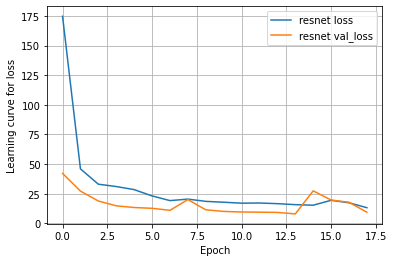

In [14]:
plot_history(
    {
        'resnet': os.path.join(manager.models_trial_path, 'resnet.csv')
    },
    metrics_='loss'
)

In [21]:
resnet.unfreeze_n_layers(7)
resnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:


count_parameters(resnet.model)

{'Total parameters': 24568113,
 'Trainable parameters': 980401,
 'Non-trainable parameters': 23587712}